## Group 3 - English to German Translation Using a Seq2Seq Based Model

Aiden Ruig

Akshan De Silva

Illias Vasiliou

Justin Lam

---

This notebook has been designed to build a deep learning model that translates basic English to German. It utilises a Sequence to Sequence based implementation, which allows us to translate with context awareness and more nuance. The notebook is structured as follows:

1. Essential Data Downloads
2. Library Imports
3. Data Preperation
4. Data Preprocessing
5. Exploratory Data Analysis
6. Model Building
7. Training and Evaluation
8. Interactive Translation
9. Visualisation of results

First, we download the necessary data. This includes torchtext 0.6, which includes the BucketIteration and Fields functions, which later versions do not.

In [ ]:
!pip install torchtext==0.6
!python -m spacy download en_core_web_sm
!python -m spacy download de_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 726.1 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 13.1 MB/s eta 0:00:00
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.16.0
    Uninstalling torchtext-0.16.0:
      Successfully uninstalled torchtext-0.16.0
2023-11-12 11:37:21.906117: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-12 11:37:21.906236: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-12 11:37:21.906294: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-12 11:37:21.923117: I tens

Then, we import the necessary packages.

In [ ]:
# Import necessary libraries
import spacy
import torch
import random
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from torchtext.data import Field, BucketIterator, TabularDataset
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from sklearn.model_selection import train_test_split
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
from nltk.translate.meteor_score import meteor_score
import nltk
from collections import Counter
from nltk.util import ngrams
import torch.nn as nn
import torch.optim as optim

Then, we download more data, intended for accuracy measurements and tokenisation.

In [ ]:
# Download necessary NLTK and Spacy data
nltk.download('wordnet')
spacy_eng = spacy.load("en_core_web_sm")
spacy_deu = spacy.load("de_core_news_sm")

[nltk_data] Downloading package wordnet to /root/nltk_data...


Here, we tokenise the data.

In [ ]:
# Tokenisation functions
def tokenize_eng(text):
    return [tok.text for tok in spacy_eng.tokenizer(text)]

def tokenize_deu(text):
    return [tok.text for tok in spacy_deu.tokenizer(text)]

Here, we specify the target and source language.

In [ ]:
# Define fields with the tokenization
SRC = Field(tokenize=tokenize_eng, init_token='<sos>', eos_token='<eos>', lower=True, include_lengths=True)
TRG = Field(tokenize=tokenize_deu, init_token='<sos>', eos_token='<eos>', lower=True)

Then, we create a CSV from our txt, for ease of use and access.

In [ ]:
# Create a DataFrame and save as a CSV for processing with TorchText
if not os.path.isfile('deu.csv'):
    with open('deu.txt', 'r', encoding='utf-8') as file:
        lines = file.readlines()
        data = [line.split('\t')[:2] for line in lines]  # Split each line and take the first two elements (EN, DE)
        df = pd.DataFrame(data, columns=["English", "German"])
        df.to_csv('deu.csv', index=False)

# Parameters
SUBSET_SIZE = 10000
RANDOM_SEED = 42  # Seed for reproducibility

# Read the dataset
df = pd.read_csv('deu.csv')

Next, we define what does into a subset. We use a mix of scoring based on frequency and some randomness. We do this in order to slightly favour commonly used words being put into subset. This is because we are using a small section of language, and given that a language has high variability, we want to maximse the chances of getting at least some translation.

In [ ]:
# Calculate word frequencies
word_freq = {}
for index, row in df.iterrows():
    for word in row['English'].split():
        word_freq[word.lower()] = word_freq.get(word.lower(), 0) + 1

# Score each sentence
df['score'] = df['English'].apply(lambda s: sum(word_freq[word.lower()] for word in s.split()))

# Normalize scores (optional)
df['score'] /= df['score'].max()

# Sample based on scores
# Higher score sentences are more likely but not guaranteed
subset_df = df.sample(n=SUBSET_SIZE, weights='score', random_state=RANDOM_SEED)

# Split the subset into train, validation, and test sets
train_df, test_df = train_test_split(subset_df, test_size=0.2, random_state=RANDOM_SEED)
valid_df, test_df = train_test_split(test_df, test_size=0.5, random_state=RANDOM_SEED)

We then create training, validation and testing subsets as CSV's.

In [ ]:
# Save the subsets as CSV files
train_df.to_csv('train_subset.csv', index=False)
valid_df.to_csv('valid_subset.csv', index=False)
test_df.to_csv('test_subset.csv', index=False)

In [ ]:
# Create Dataset
data_fields = [('src', SRC), ('trg', TRG)]
train_data, valid_data, test_data = TabularDataset.splits(
                                        path='',
                                        train='train_subset.csv',
                                        validation='valid_subset.csv',
                                        test='test_subset.csv',
                                        format='csv',
                                        fields=data_fields
                                    )

In [ ]:
# Function to load the dataset and display basic information
def load_and_display_dataset_info(file_path):
    df = pd.read_csv(file_path)
    print(df.info())
    print(df.head())
    return df

# Load and display the dataset
file_path = 'deu.csv'
df = load_and_display_dataset_info(file_path)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 192881 entries, 0 to 192880
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   English  192881 non-null  object
 1   German   192881 non-null  object
dtypes: object(2)
memory usage: 2.9+ MB
None
  English           German
0     Hi.         Hallo!\n
1     Hi.     Grüß Gott!\n
2    Run!          Lauf!\n
3    Wow!    Potzdonner!\n
4    Wow!  Donnerwetter!\n


Below, we are just trying to get some insight into how the data is organised.

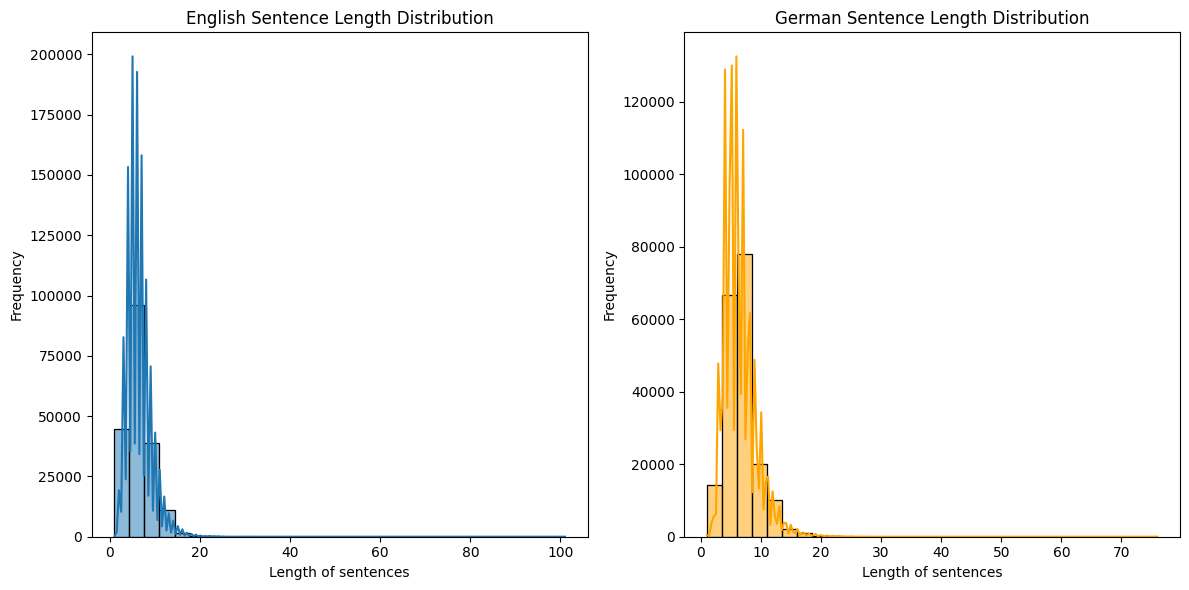

In [ ]:
def plot_sentence_length_distribution(df):
    df['English_length'] = df['English'].str.split().str.len()
    df['German_length'] = df['German'].str.split().str.len()

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    sns.histplot(df['English_length'], bins=30, kde=True)
    plt.title('English Sentence Length Distribution')
    plt.xlabel('Length of sentences')
    plt.ylabel('Frequency')

    plt.subplot(1, 2, 2)
    sns.histplot(df['German_length'], bins=30, kde=True, color='orange')
    plt.title('German Sentence Length Distribution')
    plt.xlabel('Length of sentences')
    plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()

# Plot sentence length distribution
plot_sentence_length_distribution(df)

As we can see, on average Engligh sentences are shorter, and the distribution has slightly less kurtosis, indicating that it is less distributed.

In [ ]:
# Function to extract n-grams
def extract_ngrams(data, num):
    n_grams = ngrams(data.split(), num)
    return [' '.join(grams) for grams in n_grams]

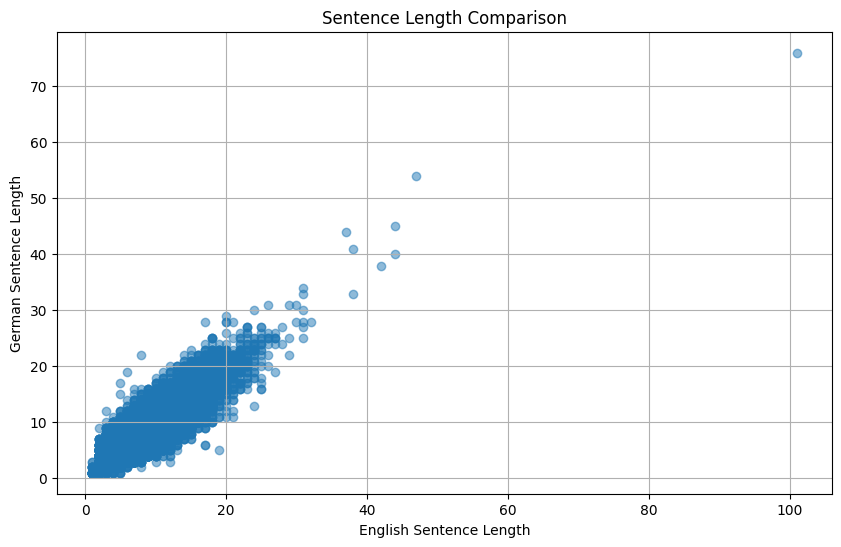

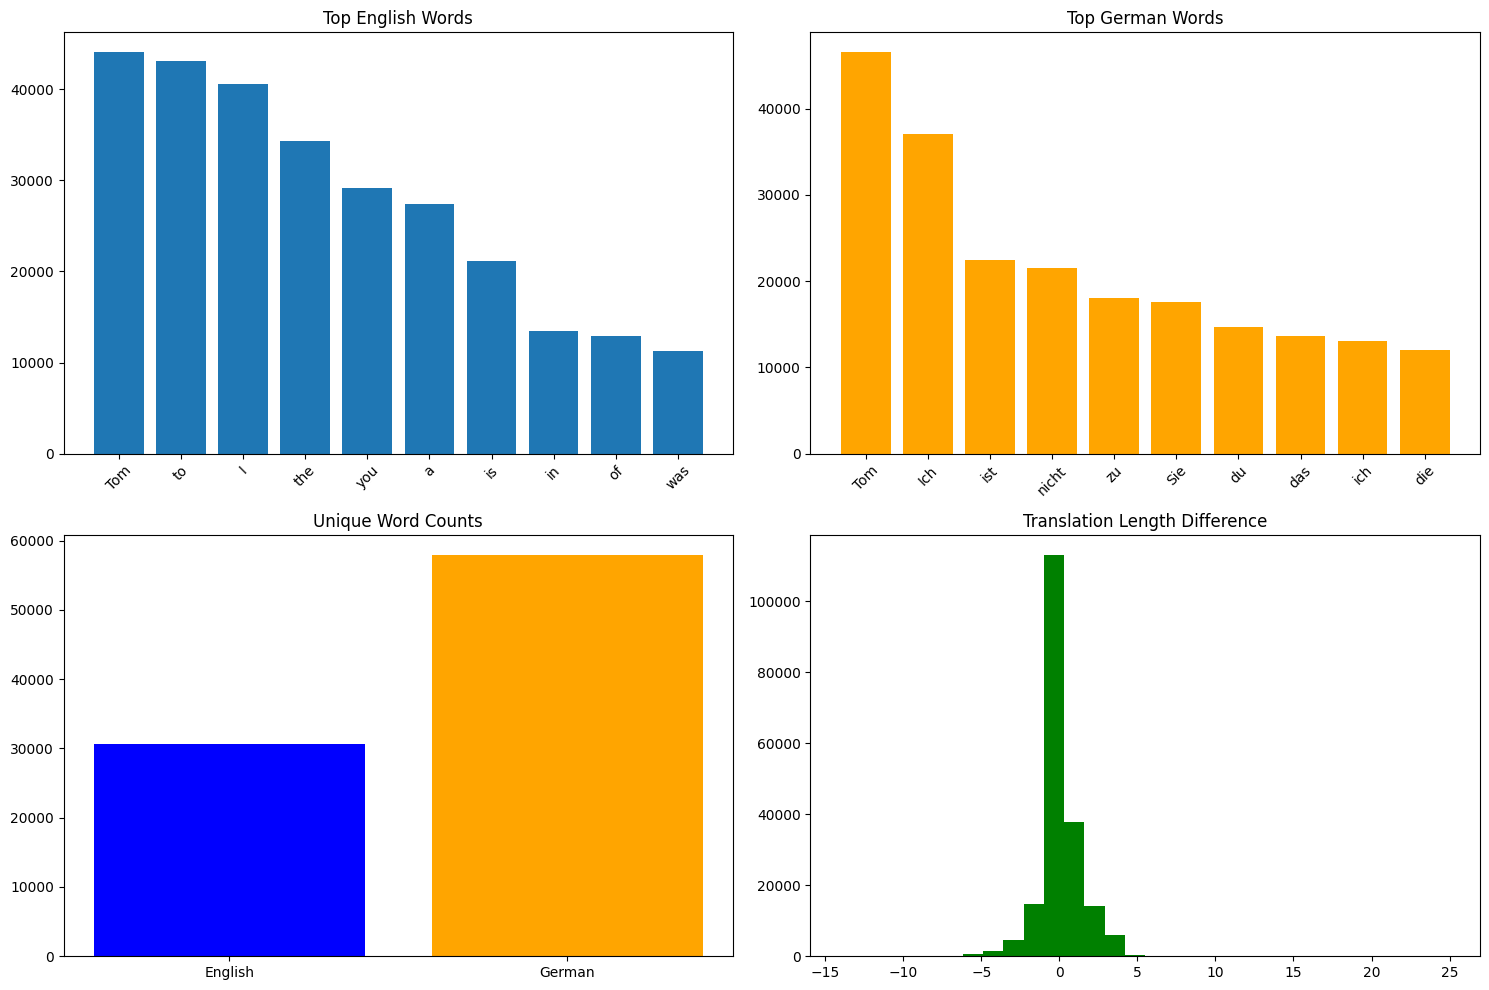

In [ ]:
# Function to calculate and display word and bigram frequencies
def calculate_and_display_frequencies(df):
    english_words = ' '.join(df['English']).split()
    german_words = ' '.join(df['German']).split()

    english_word_freq = Counter(english_words)
    german_word_freq = Counter(german_words)

    top_english_words = english_word_freq.most_common(10)
    top_german_words = german_word_freq.most_common(10)

    plt.figure(figsize=(10, 6))
    plt.scatter(df['English_length'], df['German_length'], alpha=0.5)
    plt.title('Sentence Length Comparison')
    plt.xlabel('English Sentence Length')
    plt.ylabel('German Sentence Length')
    plt.grid(True)
    plt.show()

    english_bigrams = extract_ngrams(' '.join(df['English']), 2)
    german_bigrams = extract_ngrams(' '.join(df['German']), 2)

    english_bigram_freq = Counter(english_bigrams)
    german_bigram_freq = Counter(german_bigrams)

    top_english_bigrams = english_bigram_freq.most_common(10)
    top_german_bigrams = german_bigram_freq.most_common(10)

    unique_english_words = len(set(english_words))
    unique_german_words = len(set(german_words))

    df['length_difference'] = df['English_length'] - df['German_length']

    # Plotting
    fig, axs = plt.subplots(2, 2, figsize=(15, 10))

    # Top words in English
    axs[0, 0].bar([word for word, freq in top_english_words], [freq for word, freq in top_english_words])
    axs[0, 0].set_title('Top English Words')
    axs[0, 0].set_xticks(range(len(top_english_words)))  # Adding this line
    axs[0, 0].set_xticklabels([word for word, freq in top_english_words], rotation=45)

    # Top words in German
    axs[0, 1].bar([word for word, freq in top_german_words], [freq for word, freq in top_german_words], color='orange')
    axs[0, 1].set_title('Top German Words')
    axs[0, 1].set_xticks(range(len(top_german_words)))  # Adding this line
    axs[0, 1].set_xticklabels([word for word, freq in top_german_words], rotation=45)

    axs[1, 0].bar(['English', 'German'], [unique_english_words, unique_german_words], color=['blue', 'orange'])
    axs[1, 0].set_title('Unique Word Counts')

    axs[1, 1].hist(df['length_difference'], bins=30, color='green')
    axs[1, 1].set_title('Translation Length Difference')

    plt.tight_layout()
    plt.show()

    return top_english_bigrams, top_german_bigrams

# Calculate and display frequencies
top_english_bigrams, top_german_bigrams = calculate_and_display_frequencies(df)

Here we can see a few things.
1. The length of the sentences in both languages are faily correalted.
2. The name Tom seems to be fairly common, maybe indicating that this dataset was taken from a piece of fiction, or maybe just simply created by someone called Tom.
3. English tends to have a more even spread of its most used words.
4. English has far less unique words.
5. There generally isn't a significant difference in length of English and German sentences.

After this, we can get into building out model. First we build our vocabulary.

In [ ]:
# Build Vocabulary
SRC.build_vocab(train_data, min_freq = 2)
TRG.build_vocab(train_data, min_freq = 2)

And define the batches.

In [ ]:
# Create Iterators
BATCH_SIZE = 32
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data),
    batch_size = BATCH_SIZE,
    device = device,
    sort_within_batch = True,
    sort_key = lambda x : len(x.src)
)

In [ ]:
# Check a few examples
for i, batch in enumerate(train_iterator):
    src = batch.src
    trg = batch.trg
    if i < 1:  # Print first batch
        print(f"Batch {i+1}")
        print("Source:", src)
        print("Target:", trg)
    else:
        break

Batch 1
Source: (tensor([[   2,    2,    2,    2,    2,    2,    2,    2,    2,    2,    2,    2,
            2,    2,    2,    2,    2,    2,    2,    2,    2,    2,    2,    2,
            2,    2,    2,    2,    2,    2,    2,    2],
        [  28,    7,    7,   19,    7,    7,    6,  101,    7,    7,    7,    7,
            8,   48,    7,    6,  202,  192,  335,    8,   48,   17,   28,   46,
            7,    7,    8,    7,    7,    8,    7,   85],
        [   9,   11,   20,   27,  762,   11,  205,   38,  180,   11,   20,   20,
           45,    9,  310,  464,    6,   12,    9,   39,    9,  425,    7,  170,
           57,    0,  548,   11,   57,   55, 2087,    6],
        [  21, 1374,    0,    0,    6,   70,   95,  939,  164,  229,   16, 1400,
            5,  133,   37,   11,  268,    9,   26,  125,   85,    6,   13,    0,
           10, 1417,    7,   12,    5,  120,   23,  669],
        [  10,   37,   46,    6, 1173,    5,   16,   18,   34,   10,   10, 2038,
         1359,  113,  

Next, we define the basis of our model. This is the encoder, the decoder, and the seq2seq classes. The encoder takes an input string, the decoder takes a context vector, and then seq2seq function wraps them both together.

In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hidden_dim, n_layers, dropout):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.rnn = nn.LSTM(emb_dim, hidden_dim, n_layers, dropout=dropout)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src, src_len):
        # src = [src len, batch size]
        embedded = self.dropout(self.embedding(src))

        # Pack sequence
        packed_embedded = pack_padded_sequence(embedded, src_len, enforce_sorted=False)
        packed_outputs, (hidden, cell) = self.rnn(packed_embedded)

        # Unpack (back to padded)
        outputs, _ = pad_packed_sequence(packed_outputs)

        return hidden, cell

class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hidden_dim, n_layers, dropout):
        super().__init__()
        self.output_dim = output_dim
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.rnn = nn.LSTM(emb_dim, hidden_dim, n_layers, dropout=dropout)
        self.fc_out = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input, hidden, cell):
        # input = [batch size]
        input = input.unsqueeze(0)  # input = [1, batch size]
        embedded = self.dropout(self.embedding(input))

        output, (hidden, cell) = self.rnn(embedded, (hidden, cell))
        prediction = self.fc_out(output.squeeze(0))

        return prediction, hidden, cell

class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, src, src_len, trg, teacher_forcing_ratio=0.5):
        batch_size = trg.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim

        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)

        # Encode the source sentence
        hidden, cell = self.encoder(src, src_len)

        # First input to the decoder is the <sos> token
        input = trg[0,:]

        for t in range(1, trg_len):
            output, hidden, cell = self.decoder(input, hidden, cell)
            outputs[t] = output

            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.argmax(1)
            input = trg[t] if teacher_force else top1

        return outputs

Next, we define the hyperparameters, instantiate the models, and set the optimiser as Adam, and the Loss Function as Cross Entropy. These were found as the best optimiser and loss functions through some basic experimentation.

In [ ]:
# Model hyperparameters
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

# Instantiate models
enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)

model = Seq2Seq(enc, dec, device).to(device)

# Optimizer and Loss Function
optimizer = optim.Adam(model.parameters())
PAD_IDX = TRG.vocab.stoi['<pad>']
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)

Here, we define the ability to test our own custom sentence at the end of the program, before the visualisations.

In [ ]:
def translate_sentence(sentence, src_field, trg_field, model, device, max_len=50):
    model.eval()

    # Tokenize the sentence
    if isinstance(sentence, str):
        tokens = [token.text.lower() for token in spacy_eng(sentence)]
    else:
        tokens = [token.lower() for token in sentence]

    # Add <sos> and <eos> tokens
    tokens = [src_field.init_token] + tokens + [src_field.eos_token]

    # Convert tokens to indices
    src_indexes = [src_field.vocab.stoi[token] for token in tokens]

    # Convert to tensor and add batch dimension
    src_tensor = torch.LongTensor(src_indexes).unsqueeze(1).to(device)
    src_len = torch.LongTensor([len(src_indexes)]).to(device)

    # Translation
    with torch.no_grad():
        hidden, cell = model.encoder(src_tensor, src_len)

    trg_indexes = [trg_field.vocab.stoi[trg_field.init_token]]

    for i in range(max_len):
        trg_tensor = torch.LongTensor([trg_indexes[-1]]).to(device)

        with torch.no_grad():
            output, hidden, cell = model.decoder(trg_tensor, hidden, cell)

        pred_token = output.argmax(1).item()
        trg_indexes.append(pred_token)

        if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
            break

    # Convert indices to tokens
    trg_tokens = [trg_field.vocab.itos[i] for i in trg_indexes]

    # Return the translated sentence (skip <sos> token)
    return trg_tokens[1:]

Then, we define the BLEU measure, which tests machine translated text in comparison to a set of human translated text. We use a smoothing function to account for the small size of our subset.

In [ ]:
def calculate_bleu(data, src_field, trg_field, model, device, max_len=50):
    targets = []
    outputs = []

    for example in data:
        src = vars(example)['src']
        trg = vars(example)['trg']

        prediction = translate_sentence(src, src_field, trg_field, model, device, max_len)
        prediction = prediction[:-1]  # remove <eos> token

        targets.append([trg])
        outputs.append(prediction)

    # Use a smoothing function
    smoothie = SmoothingFunction().method1
    return corpus_bleu(targets, outputs, smoothing_function=smoothie)

Here, we define the METEOR measure. It is a similar measure to BLEU but it has slightly better correlation with real human judgement.

In [ ]:
def calculate_meteor(data, src_field, trg_field, model, device, max_len=50):
    references = []
    hypotheses = []

    for example in data:
        src = vars(example)['src']
        trg = vars(example)['trg']

        prediction = translate_sentence(src, src_field, trg_field, model, device, max_len)
        prediction = prediction[:-1]  # Remove <eos> token

        references.append(trg)
        hypotheses.append(prediction)

    # Calculate METEOR for each hypothesis against references
    meteor_scores = [nltk.translate.meteor_score.meteor_score([ref], hyp) for ref, hyp in zip(references, hypotheses)]
    average_meteor_score = sum(meteor_scores) / len(meteor_scores)
    return average_meteor_score

Then, we run the training loop.

In [ ]:
def train(model, iterator, optimizer, criterion, clip):
    model.train()
    epoch_loss = 0
    total_correct = 0
    total_tokens = 0

    for _, batch in enumerate(iterator):
        src, src_len = batch.src
        trg = batch.trg

        optimizer.zero_grad()
        output = model(src, src_len, trg)

        # trg = [trg len, batch size]
        # output = [trg len, batch size, output dim]
        output_dim = output.shape[-1]

        output = output[1:].view(-1, output_dim)
        trg = trg[1:].view(-1)

        loss = criterion(output, trg)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()

        epoch_loss += loss.item()

        # Calculate accuracy
        total_correct += (output.argmax(dim=1) == trg).sum().item()
        total_tokens += trg.numel()

    accuracy = total_correct / total_tokens
    return epoch_loss / len(iterator), accuracy

Here, we set the number of epochs, as well as create lists, in order to graph the metrics later on.

In [ ]:
# Training loop with epoch tracker
N_EPOCHS = 20
CLIP = 1

#
train_losses = []
train_accuracies = []
bleu_scores = []
meteor_scores = []

Then, we actually train and evaluate the model.

In [ ]:
for epoch in range(N_EPOCHS):
    # Calculate and display Training loss, Accuracy and Epoch
    train_loss, train_accuracy = train(model, train_iterator, optimizer, criterion, CLIP)
    print(f'Epoch: {epoch+1:02}')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_accuracy * 100:.2f}%')

    # Calculate and display BLEU score
    bleu_score = calculate_bleu(test_data, SRC, TRG, model, device)
    print(f'BLEU score = {bleu_score*100:.2f}')

    # Calculate and display METEOR score
    meteor_score_value = calculate_meteor(test_data, SRC, TRG, model, device)
    print(f'METEOR Score = {meteor_score_value:.2f}')

    # Append metrics to lists
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    bleu_scores.append(bleu_score)
    meteor_scores.append(meteor_score_value)

epochs = range(1, N_EPOCHS + 1)

Epoch: 01
	Train Loss: 4.860 | Train Acc: 15.24%
BLEU score = 0.10
METEOR Score = 0.15
Epoch: 02
	Train Loss: 4.228 | Train Acc: 20.12%
BLEU score = 0.46
METEOR Score = 0.17
Epoch: 03
	Train Loss: 3.939 | Train Acc: 22.29%
BLEU score = 2.88
METEOR Score = 0.20
Epoch: 04
	Train Loss: 3.699 | Train Acc: 23.88%
BLEU score = 4.05
METEOR Score = 0.23
Epoch: 05
	Train Loss: 3.507 | Train Acc: 25.28%
BLEU score = 4.72
METEOR Score = 0.25
Epoch: 06
	Train Loss: 3.318 | Train Acc: 26.28%
BLEU score = 5.89
METEOR Score = 0.26
Epoch: 07
	Train Loss: 3.164 | Train Acc: 27.22%
BLEU score = 6.29
METEOR Score = 0.27
Epoch: 08
	Train Loss: 3.006 | Train Acc: 28.21%
BLEU score = 6.60
METEOR Score = 0.28
Epoch: 09
	Train Loss: 2.874 | Train Acc: 28.81%
BLEU score = 7.44
METEOR Score = 0.29
Epoch: 10
	Train Loss: 2.747 | Train Acc: 29.44%
BLEU score = 8.02
METEOR Score = 0.30
Epoch: 11
	Train Loss: 2.620 | Train Acc: 30.31%
BLEU score = 8.84
METEOR Score = 0.31
Epoch: 12
	Train Loss: 2.486 | Train Acc: 3

As you can see, we did not score well on either the BLEU score (out of 100), or the METEOR score (0-1). However, this was not our best recorded result - our best result had an accuracy of 50%, a BLEU score of 16%, and a METEOR score of 0.4. Considering the size of our subset, this is a respectable performance.

Next, we run a while loop in order to test our own custom sentences.

In [ ]:
# Example usage
while True:
    sentence = input("Please enter a sentence to translate (x to end): ")
    translation = translate_sentence(sentence, SRC, TRG, model, device)
    print(" ".join(translation))
    if sentence == 'x':
        break

Please enter a sentence to translate (x to end): I am in
ich bin . <eos>
Please enter a sentence to translate (x to end): I am Tom
ich <unk> . <eos>
Please enter a sentence to translate (x to end): He is Tom
er <unk> tom . <eos>
Please enter a sentence to translate (x to end): We are cool.
wir sind gegen . <eos>
Please enter a sentence to translate (x to end): We are not.
wir sind nicht . <eos>
Please enter a sentence to translate (x to end): Not cool.
es regnet keine . <eos>
Please enter a sentence to translate (x to end): We are all here.
wir sind hier hier . <eos>
Please enter a sentence to translate (x to end): What is going on?
was macht das ? <eos>
Please enter a sentence to translate (x to end): How are you today?
wie seht du wütend ? <eos>
Please enter a sentence to translate (x to end): How are you?
wie kommst du ? <eos>
Please enter a sentence to translate (x to end): What is happening?
was ist da ? <eos>
Please enter a sentence to translate (x to end): Hello!
<unk> sie . <eo

It performs well on simple and common sentences, such as "How are you?", however we perform not as well on more complex or uncommon sentences. In this case, when translated back to English, the model incorrectly translated "We are cool." to "We are against". Maybe the model is just a fan of rebellion, and being against something is cool. But it's more likely that this is a reflectin of its training limitations.

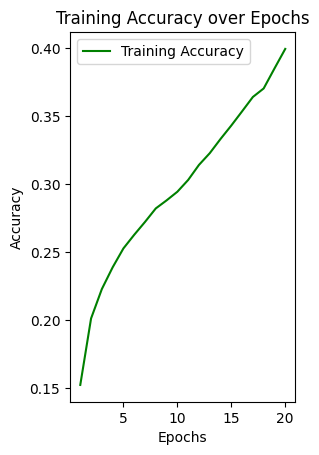

In [ ]:
# Plotting training accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Training Accuracy', color='green')
plt.title('Training Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

The training accuracy shows a mostly linear correlation with number of epochs. This is a good sign as it shows that the model is fitting better to the dataset upon every iteration.

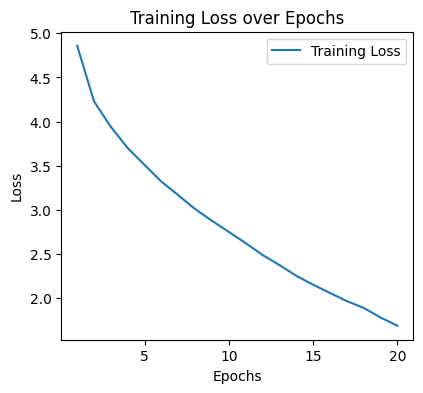

In [ ]:
# Plotting training loss
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Training Loss')
plt.title('Training Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

This graph also shows similarly that loss seems to be decreasing over every epoch. This is also a good sign as it indicates that that model is likely not stagnating, and if given more time will likely get better.

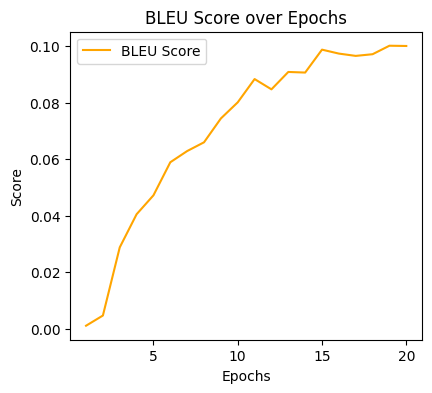

In [ ]:
# Plotting BLEU and METEOR scores
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, bleu_scores, label='BLEU Score', color='orange')
plt.title('BLEU Score over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.legend()

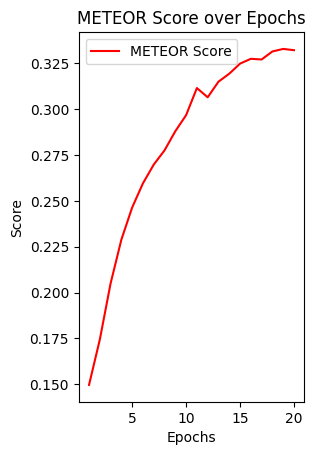

In [ ]:
plt.subplot(1, 2, 2)
plt.plot(epochs, meteor_scores, label='METEOR Score', color='red')
plt.title('METEOR Score over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.legend()
plt.show()

Last but not least, the progression of the METEOR and BLEU scores both show that at around epoch 12, these scores start to stagnate. This is to be expected, as even though the model is fitting to the dataset well, the limited size of the dataset likely means that these scores will start to stagnate. This is simply because no matter how much it trains, it can't create new words, and will inevitably have a large portion of the language being translated with an <<unk>unk> token.